In [1]:
import sys
sys.path.append("../") 

from src.utils.driver import set_seed

set_seed(57)

### Define Model and Dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.utils.model import DistLayer

# Define the model class
class SimpleNN(nn.Module):
    def __init__(self, harmonic=False):
        super(SimpleNN, self).__init__()
        self.harmonic = harmonic
        if harmonic:
            self.fc1 = DistLayer(28 * 28, 10, n=28.)
        else:
            self.fc1 = nn.Linear(28 * 28, 10)
        nn.init.normal_(self.fc1.weight, mean=0, std=1/28.)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        if self.harmonic:
            prob = x/torch.sum(x, dim=1, keepdim=True)
            logits = (-1)*torch.log(prob)
            return logits
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
max_epochs = 100

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Harmonic Model

In [3]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(harmonic=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

patience = 10
min_delta = 1e-4
best_loss = 1e9

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = outputs[range(targets.size(0)), targets].mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
        
    # Early stopping check
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}")

    if epochs_no_improve >= patience:
        print(f"Stopping training. No improvement for {patience} epochs.")
        break

# Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = (-1)*model(data)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()

accuracy = correct / len(test_dataset) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "../results/mnist_harmonic.pth")

Epoch [1], Loss: 0.6199
Epoch [11], Loss: 0.2646
Epoch [21], Loss: 0.2550
Epoch [31], Loss: 0.2516
Epoch [41], Loss: 0.2504
Epoch [51], Loss: 0.2499
Epoch [61], Loss: 0.2497
Epoch [71], Loss: 0.2495
Stopping training. No improvement for 10 epochs.
Test Accuracy: 92.49%


/tmp/ipykernel_1823847/4152671310.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("../results/mnist_harmonic.pth")


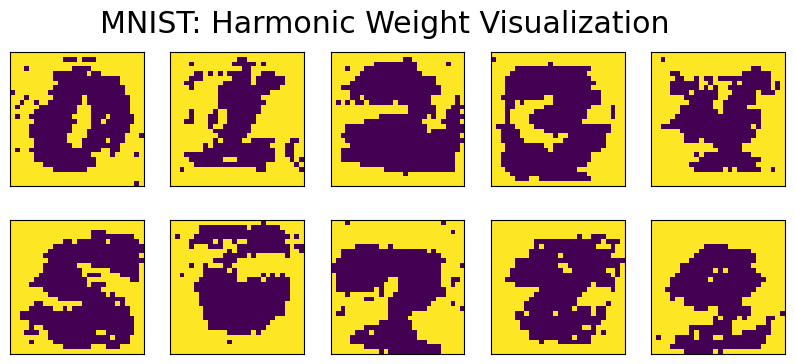

In [8]:
import matplotlib.pyplot as plt
import numpy as np

weights = torch.load("../results/mnist_harmonic.pth")

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.suptitle("MNIST: Harmonic Weight Visualization")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    weight = weights['fc1.weight'][i].reshape(28, 28).detach().numpy()
    weight = np.where(weight < 0.01, 1, 0)
    plt.imshow(weight)
#    plt.axis("off")
    plt.xticks([])
    plt.yticks([])

plt.savefig("../figures/mnist_harmonic_weights.pdf", bbox_inches="tight")

### Standard Model

In [5]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(harmonic=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

patience = 10
min_delta = 1e-4
best_loss = 1e9

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
        
    # Early stopping check
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 10 == 0:
        print(f"Epoch [{epoch + 1}], Loss: {running_loss / len(train_loader):.4f}")

    if epochs_no_improve >= patience:
        print(f"Stopping training. No improvement for {patience} epochs.")
        break

# Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()

accuracy = correct / len(test_dataset) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
torch.save(model.state_dict(), "../results/mnist_standard.pth")


Epoch [1], Loss: 0.5467
Epoch [11], Loss: 0.2539
Epoch [21], Loss: 0.2429
Epoch [31], Loss: 0.2375
Epoch [41], Loss: 0.2346
Epoch [51], Loss: 0.2326
Epoch [61], Loss: 0.2311
Epoch [71], Loss: 0.2297
Epoch [81], Loss: 0.2294
Epoch [91], Loss: 0.2285
Test Accuracy: 92.50%


/tmp/ipykernel_1823847/3949916341.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("../results/mnist_standard.pth")


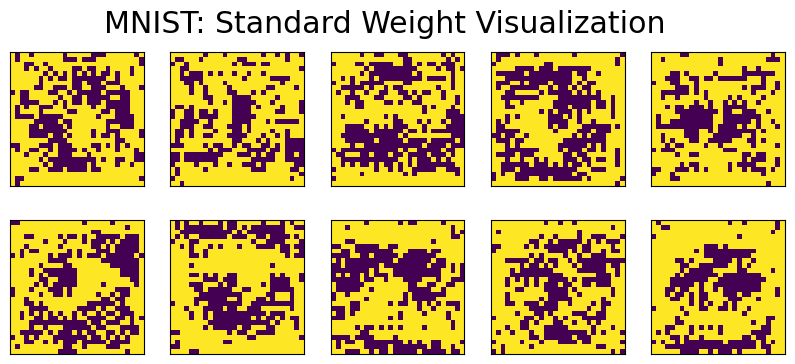

In [7]:
import matplotlib.pyplot as plt
import numpy as np

weights = torch.load("../results/mnist_standard.pth")

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.suptitle("MNIST: Standard Weight Visualization")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    weight = weights['fc1.weight'][i].reshape(28, 28).detach().numpy()
    weight = np.where(weight < 0.01, 1, 0)
    plt.imshow(weight)
    plt.xticks([])
    plt.yticks([])

#plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig("../figures/mnist_standard_weights.pdf", bbox_inches="tight")